In [1]:
import theano
import theano.tensor as T
import numpy as np
import pandas as pd
import cPickle as pkl
from matplotlib import pyplot as plt

In [14]:
""" Linear Total Correlation Explanation
Recovers linear latent factors from data, like PCA/ICA/FA, etc. except that
these factors are maximally informative about relationships in the data.
We also constrain our solutions to be "non-synergistic" for better interpretability.
(That is the TC(Y|Xi)=0 constraint in the "blessing of dimensionality" paper.)
Code below written by:
Greg Ver Steeg (gregv@isi.edu), 2017.
"""

from scipy.stats import norm, rankdata
import gc
try:
    import cudamat as cm
    GPU_SUPPORT = True
except:
    print("Install CUDA and cudamat (for python) to enable GPU speedups.")
    GPU_SUPPORT = False


class Corex(object):
    """
    Linear Total Correlation Explanation
    Conventions
    ----------
    Code follows sklearn naming/style (e.g. fit(X) to train, transform() to apply model to test data).
    Parameters
    ----------
    n_hidden : int, default = 2
        The number of latent factors to use.
    max_iter : int, default = 10000
        The max. number of iterations to reach convergence.
    tol : float, default = 0.0001
        Used to test for convergence.
    eliminate_synergy : bool, default = True
        Use a constraint that the information latent factors have about data is not synergistic.
    gaussianize : str, default = 'standard'
        Preprocess data so each marginal is near a standard normal. See gaussianize method for more details.
    yscale : float default = 1
        We imagine some small fundamental measurement noise on Y. The value is arbitrary, but it sets
        the scale of the results, Y.
    verbose : int, optional
        Print verbose outputs.
    seed : integer or numpy.RandomState, optional
        A random number generator instance to define the state of the
        random permutations generator. If an integer is given, it fixes the
        seed. Defaults to the global numpy random number generator.
    Attributes
    ----------
    References
    ----------
    [1] Greg Ver Steeg and Aram Galstyan. "Maximally Informative Hierarchical...", AISTATS 2015.
    [2] Greg Ver Steeg, Shuyang Gao, Kyle Reing, and Aram Galstyan. "Sifting Common Information from Many Variables",
                                                                    IJCAI 2017.
    [3] Greg Ver Steeg and Aram Galstyan. "Low Complexity Gaussian Latent Factor Models and
                                           a Blessing of Dimensionality", 2017.
    """

    def __init__(self, n_hidden=10, max_iter=10000, tol=1e-5, anneal=True, missing_values=None,
                 discourage_overlap=True, gaussianize='standard', gpu=False,
                 verbose=False, seed=None):
        self.m = n_hidden  # Number of latent factors to learn
        self.max_iter = max_iter  # Number of iterations to try
        self.tol = tol  # Threshold for convergence
        self.anneal = anneal
        self.eps = 0  # If anneal is True, it's adjusted during optimization to avoid local minima
        self.missing_values = missing_values

        self.discourage_overlap = discourage_overlap  # Whether or not to discourage overlapping latent factors
        self.gaussianize = gaussianize  # Preprocess data: 'standard' scales to zero mean and unit variance
        self.gpu = gpu  # Enable GPU support for some large matrix multiplications.
        if self.gpu:
            cm.cublas_init()

        self.yscale = 1.  # Can be arbitrary, but sets the scale of Y
        np.random.seed(seed)  # Set seed for deterministic results
        self.verbose = verbose
        if verbose:
            np.set_printoptions(precision=3, suppress=True, linewidth=160)
            print(('Linear CorEx with {:d} latent factors'.format(n_hidden)))

        # Initialize these when we fit on data
        self.n_samples, self.nv = 0, 0  # Number of samples/variables in input data
        self.ws = np.zeros((0, 0))  # m by nv array of weights
        self.moments = {}  # Dictionary of moments
        self.theta = None  # Parameters for preprocessing each variable
        self.history = {}  # Keep track of values for each iteration
        self.last_update = 0  # Used for momentum methods

    def fit_transform(self, x):
        self.fit(x)
        return self.transform(x)

    def fit(self, x):
        x = np.asarray(x, dtype=np.float32)
        x = self.preprocess(x, fit=True)  # Fit a transform for each marginal
        self.n_samples, self.nv = x.shape  # Number of samples, variables in input data
        if self.m is None:
            self.m = pick_n_hidden(x)
        anneal_schedule = [0.]
        if self.ws.size == 0:  # Randomly initialize weights if not already set
            if self.discourage_overlap:
                self.ws = np.random.randn(self.m, self.nv).astype(np.float32)
                self.ws /= (10. * self._norm(x, self.ws))[:, np.newaxis]  # TODO: test good IC
                if self.anneal:
                    anneal_schedule = [0.6**k for k in range(1, 7)] + [0]
            else:
                self.ws = np.random.randn(self.m, self.nv) * self.yscale ** 2 / np.sqrt(self.nv)
        self.moments = self._calculate_moments(x, self.ws, quick=True)

        for i_eps, eps in enumerate(anneal_schedule):
            self.eps = eps
            if i_eps > 0:
                eps0 = anneal_schedule[i_eps - 1]
                mag = (1 - self.yscale**2 / self.moments['Y_j^2']).clip(1e-5)  # May be better to re-initialize un-used latent factors (i.e. yj^2=self.yscale**2)?
                wmag = np.sum(self.ws**2, axis=1)
                self.ws *= np.sqrt((1 - eps0**2) / (1 - eps**2 - (eps0**2 - eps**2) * wmag / mag))[:, np.newaxis]
            self.moments = self._calculate_moments(x, self.ws, quick=True)

            for i_loop in range(self.max_iter):
                last_tc = self.tc  # Save this TC to compare to possible updates
                if self.discourage_overlap:
                    self.ws, self.moments = self._update_ns(x)
                else:
                    self.ws, self.moments = self._update_syn(x, eta=0.1)  # Older method that allows synergies

                # assert np.isfinite(self.tc), "Error: TC is no longer finite: {}".format(self.tc)
                if not self.moments or not np.isfinite(self.tc):
                    try:
                        print(("Error: TC is no longer finite: {}".format(self.tc)))
                    except:
                        print("Error... updates giving invalid solutions?")
                        return self
                delta = np.abs(self.tc - last_tc)
                self.update_records(self.moments, delta)  # Book-keeping
                if delta < self.tol:  # Check for convergence
                    if self.verbose:
                        print(('{:d} iterations to tol: {:f}'.format(i_loop, self.tol)))
                    break
            else:
                if self.verbose:
                    print(("Warning: Convergence not achieved in {:d} iterations. "
                          "Final delta: {:f}".format(self.max_iter, delta.sum())))
        self.moments = self._calculate_moments(x, self.ws, quick=False)  # Update moments with details
        order = np.argsort(-self.moments["TCs"])  # Largest TC components first.
        self.ws = self.ws[order]
        self.moments = self._calculate_moments(x, self.ws, quick=False)  # Update moments based on sorted weights.
        return self

    def update_records(self, moments, delta):
        """Print and store some statistics about each iteration."""
        gc.disable()  # There's a bug that slows when appending, fixed by temporarily disabling garbage collection
        self.history["TC"] = self.history.get("TC", []) + [moments["TC"]]
        if self.verbose > 1:
            print(("TC={:.3f}\tadd={:.3f}\tdelta={:.6f}".format(moments["TC"], moments.get("additivity", 0), delta)))
        if self.verbose:
            self.history["additivity"] = self.history.get("additivity", []) + [moments.get("additivity", 0)]
            self.history["TCs"] = self.history.get("TCs", []) + [moments.get("TCs", np.zeros(self.m))]
        gc.enable()

    @property
    def tc(self):
        """This actually returns the lower bound on TC that is optimized. The lower bound assumes a constraint that
         would be satisfied by a non-overlapping model.
         Check "moments" for two other estimates of TC that may be useful."""
        return self.moments["TC"]

    @property
    def tcs(self):
        """TCs for each individual latent factor. They DO NOT sum to TC in this case, because of overlaps."""
        return self.moments["TCs"]

    @property
    def mis(self):
        return - 0.5 * np.log1p(-self.moments["rho"]**2)

    def clusters(self):
        return np.argmax(np.abs(self.ws), axis=0)

    def _sig(self, x, u):
        """Multiple the matrix u by the covariance matrix of x. We are interested in situations where
        n_variables >> n_samples, so we do this without explicitly constructing the covariance matrix."""
        if self.gpu:
            y = cm.empty((self.n_samples, self.m))
            uc = cm.CUDAMatrix(u)
            cm.dot(x, uc.T, target=y)
            del uc
            tmp = cm.empty((self.nv, self.m))
            cm.dot(x.T, y, target=tmp)
            tmp_dot = tmp.asarray()
            del y
            del tmp
        else:
            y = x.dot(u.T)
            tmp_dot = x.T.dot(y)
        prod = (1 - self.eps**2) * tmp_dot.T / self.n_samples + self.eps**2 * u  # nv by m,  <X_i Y_j> / std Y_j
        return prod

    def _norm(self, x, ws):
        """Calculate uj so that we can normalize it."""
        if self.gpu:
            y = cm.empty((self.n_samples, self.m))
            wc = cm.CUDAMatrix(ws)
            cm.dot(x, wc.T, target=y)  # + noise, but it is included analytically
            y_local = y.asarray()
            del y
            del wc
            tmp_sum = np.einsum('lj,lj->j', y_local, y_local)  # TODO: Should be able to do on gpu...
        else:
            y = x.dot(ws.T)  # + noise / std Y_j^2, but it is included analytically
            tmp_sum = np.einsum('lj,lj->j', y, y)
        return np.sqrt((1 - self.eps**2) * tmp_sum / self.n_samples + self.eps**2 * np.sum(ws**2, axis=1))

    def _calculate_moments(self, x, ws, quick=False):
        if self.discourage_overlap:
            return self._calculate_moments_ns(x, ws, quick=quick)
        else:
            return self._calculate_moments_syn(x, ws, quick=quick)

    def _calculate_moments_ns(self, x, ws, quick=False):
        """Calculate moments based on the weights and samples. We also calculate and save MI, TC, additivity, and
        the value of the objective. Note it is assumed that <X_i^2> = 1! """
        m = {}  # Dictionary of moments
        if self.gpu:
            y = cm.empty((self.n_samples, self.m))
            wc = cm.CUDAMatrix(ws)
            cm.dot(x, wc.T, target=y)  # + noise, but it is included analytically
            del wc
            tmp_sum = np.einsum('lj,lj->j', y.asarray(), y.asarray())  # TODO: Should be able to do on gpu...
        else:
            y = x.dot(ws.T)
            tmp_sum = np.einsum('lj,lj->j', y, y)
        m["uj"] = (1 - self.eps**2) * tmp_sum / self.n_samples + self.eps**2 * np.sum(ws**2, axis=1)
        if quick and np.max(m["uj"]) >= 1.:
            return False
        if self.gpu:
            tmp = cm.empty((self.nv, self.m))
            cm.dot(x.T, y, target=tmp)
            tmp_dot = tmp.asarray()
            del tmp
            del y
        else:
            tmp_dot = x.T.dot(y)
        m["rho"] = (1 - self.eps**2) * tmp_dot.T / self.n_samples + self.eps**2 * ws  # m by nv
        m["ry"] = ws.dot(m["rho"].T)  # normalized covariance of Y
        m["Y_j^2"] = self.yscale ** 2 / (1. - m["uj"])
        np.fill_diagonal(m["ry"], 1)
        m["invrho"] = 1. / (1. - m["rho"]**2)
        m["rhoinvrho"] = m["rho"] * m["invrho"]
        m["Qij"] = np.dot(m['ry'], m["rhoinvrho"])
        m["Qi"] = np.einsum('ki,ki->i', m["rhoinvrho"], m["Qij"])
        #m["Qi-Si^2"] = np.einsum('ki,ki->i', m["rhoinvrho"], m["Qij"])
        m["Si"] = np.sum(m["rho"] * m["rhoinvrho"], axis=0)

        # This is the objective, a lower bound for TC
        m["TC"] = np.sum(np.log(1 + m["Si"])) \
                     - 0.5 * np.sum(np.log(1 - m["Si"]**2 + m["Qi"])) \
                     + 0.5 * np.sum(np.log(1 - m["uj"]))

        if not quick:
            m["MI"] = - 0.5 * np.log1p(-m["rho"]**2)
            m["X_i Y_j"] = m["rho"].T * np.sqrt(m["Y_j^2"])
            m["X_i Z_j"] = np.linalg.solve(m["ry"], m["rho"]).T
            m["X_i^2 | Y"] = (1. - np.einsum('ij,ji->i', m["X_i Z_j"], m["rho"])).clip(1e-6)
            m['I(Y_j ; X)'] = 0.5 * np.log(m["Y_j^2"]) - 0.5 * np.log(self.yscale ** 2)
            m['I(X_i ; Y)'] = - 0.5 * np.log(m["X_i^2 | Y"])
            m["TCs"] = m["MI"].sum(axis=1) - m['I(Y_j ; X)']
            m["TC_no_overlap"] = m["MI"].max(axis=0).sum() - m['I(Y_j ; X)'].sum()  # A direct calculation of TC where each variable is in exactly one group.
            m["TC_direct"] = m['I(X_i ; Y)'].sum() - m['I(Y_j ; X)']  # A direct calculation of TC. Should be upper bound for "TC", "TC_no_overlap"
            m["additivity"] = (m["MI"].sum(axis=0) - m['I(X_i ; Y)']).sum()
        return m

    def _update_ns(self, x):
        """Perform one update of the weights and re-calculate moments in the NON-SYNERGISTIC case."""
        m = self.moments
        rj = 1. - m["uj"][:, np.newaxis]
        H = np.dot(m["rhoinvrho"] / (1 + m["Qi"] - m["Si"]**2), m["rhoinvrho"].T)
        np.fill_diagonal(H, 0)
        grad = self.ws / rj
        grad -= 2 * m["invrho"] * m["rhoinvrho"] / (1 + m["Si"])
        grad += m["invrho"]**2 * \
               ((1 + m["rho"]**2) * m["Qij"] - 2 * m["rho"] * m["Si"]) / (1 - m["Si"]**2 + m["Qi"])
        grad += np.dot(H, self.ws)
        
        
        
        
        sig_grad = self._sig(x, grad)
        """
        Bj = np.sum(m["rho"] * grad, axis=1, keepdims=True)
        update = - rj * (grad - 2. * self.ws / (2 - rj) * Bj)  # Gamma Hess^-1 Grad
        update = np.where(rj < 1e-6, 0, update)
        """

        update = -grad
        backtrack = True
        eta = 1.
        update_tangent = np.einsum('ji,ji', sig_grad, update)
        while backtrack:
            if eta < min(self.tol, 1e-10):
                if self.verbose:
                    print('Warning: step size becoming too small')
                break
            w_update = self.ws + eta * update
            m_update = self._calculate_moments_ns(x, w_update, quick=True)
            if not m_update:  # TEST 1: Make sure rho is a valid solution, if not m_update will return False
                eta *= 0.5
                if self.verbose > 1:
                    print(('back:{:.7f}'.format(eta)))
                continue
            wolfe1 = -m_update['TC'] <= -m['TC'] + 0.1 * eta * update_tangent
            if not wolfe1:  # TEST 2: the first wolfe condition (sufficient decrease)
                eta *= 0.5
                if self.verbose > 1:
                    print(('wolfe1:{:.7f}'.format(eta)))
                continue
            backtrack = False
        
        print("TC = {}".format(self.tc))
        
        return w_update, m_update

    def _calculate_moments_syn(self, x, ws, quick=False):
        """Calculate moments based on the weights and samples. We also calculate and save MI, TC, additivity, and
        the value of the objective. Note it is assumed that <X_i^2> = 1! """
        m = {}  # Dictionary of moments
        if self.gpu:
            y = cm.empty((self.n_samples, self.m))
            wc = cm.CUDAMatrix(ws)
            cm.dot(x, wc.T, target=y)  # + noise, but it is included analytically
            del wc
        else:
            y = x.dot(ws.T)  # + noise, but it is included analytically
        if self.gpu:
            tmp_dot = cm.empty((self.nv, self.m))
            cm.dot(x.T, y, target=tmp_dot)
            m["X_i Y_j"] = tmp_dot.asarray() / self.n_samples  # nv by m,  <X_i Y_j>
            del y
            del tmp_dot
        else:
            m["X_i Y_j"] = x.T.dot(y) / self.n_samples
        m["cy"] = ws.dot(m["X_i Y_j"]) + self.yscale ** 2 * np.eye(self.m)  # cov(y.T), m by m
        m["Y_j^2"] = np.diag(m["cy"]).copy()
        m["ry"] = m["cy"] / (np.sqrt(m["Y_j^2"]) * np.sqrt(m["Y_j^2"][:, np.newaxis]))
        m["rho"] = (m["X_i Y_j"] / np.sqrt(m["Y_j^2"])).T
        m["invrho"] = 1. / (1. - m["rho"]**2)
        m["rhoinvrho"] = m["rho"] * m["invrho"]
        m["Qij"] = np.dot(m['ry'], m["rhoinvrho"])
        m["Qi"] = np.einsum('ki,ki->i', m["rhoinvrho"], m["Qij"])
        m["Si"] = np.sum(m["rho"] * m["rhoinvrho"], axis=0)

        m["MI"] = - 0.5 * np.log1p(-m["rho"]**2)
        m["X_i Z_j"] = np.linalg.solve(m["cy"], m["X_i Y_j"].T).T
        m["X_i^2 | Y"] = (1. - np.einsum('ij,ij->i', m["X_i Z_j"], m["X_i Y_j"])).clip(1e-6)
        mi_yj_x = 0.5 * np.log(m["Y_j^2"]) - 0.5 * np.log(self.yscale ** 2)
        mi_xi_y = - 0.5 * np.log(m["X_i^2 | Y"])
        m["TCs"] = m["MI"].sum(axis=1) - mi_yj_x
        m["additivity"] = (m["MI"].sum(axis=0) - mi_xi_y).sum()
        m["TC"] = np.sum(mi_xi_y) - np.sum(mi_yj_x)
        return m

    def _update_syn(self, x, eta=0.5):
        """Perform one update of the weights and re-calculate moments in the SYNERGISTIC case."""
        m = self.moments
        H = (1. / m["X_i^2 | Y"] * m["X_i Z_j"].T).dot(m["X_i Z_j"])
        np.fill_diagonal(H, 0)
        R = m["X_i Z_j"].T / m["X_i^2 | Y"]
        S = np.dot(H, self.ws)
        ws = (1. - eta) * self.ws + eta * (R - S)
        m = self._calculate_moments_syn(x, ws)
        return ws, m

    def transform(self, x, details=False):
        """Transform an array of inputs, x, into an array of k latent factors, Y.
            Optionally, you can get the remainder information and/or stop at a specified level."""
        x = self.preprocess(x)
        ns, nv = x.shape
        assert self.nv == nv, "Incorrect number of variables in input, %d instead of %d" % (nv, self.nv)
        if details:
            moments = self._calculate_moments(x, self.ws)
            return x.dot(self.ws.T), moments
        return x.dot(self.ws.T)

    def preprocess(self, x, fit=False):
        """Transform each marginal to be as close to a standard Gaussian as possible.
        'standard' (default) just subtracts the mean and scales by the std.
        'empirical' does an empirical gaussianization (but this cannot be inverted).
        'outliers' tries to squeeze in the outliers
        Any other choice will skip the transformation."""
        if self.missing_values is not None:
            x, self.n_obs = mean_impute(x, self.missing_values)  # Creates a copy
        else:
            self.n_obs = len(x)
        if self.gaussianize == 'none':
            pass
        elif self.gaussianize == 'standard':
            if fit:
                mean = np.mean(x, axis=0)
                # std = np.std(x, axis=0, ddof=0).clip(1e-10)
                std = np.sqrt(np.sum((x - mean)**2, axis=0) / self.n_obs).clip(1e-10)
                self.theta = (mean, std)
            x = ((x - self.theta[0]) / self.theta[1])
            if np.max(np.abs(x)) > 6 and self.verbose:
                print("Warning: outliers more than 6 stds away from mean. Consider using gaussianize='outliers'")
        elif self.gaussianize == 'outliers':
            if fit:
                mean = np.mean(x, axis=0)
                std = np.std(x, axis=0, ddof=0).clip(1e-10)
                self.theta = (mean, std)
            x = g((x - self.theta[0]) / self.theta[1])  # g truncates long tails
        elif self.gaussianize == 'empirical':
            print("Warning: correct inversion/transform of empirical gauss transform not implemented.")
            x = np.array([norm.ppf((rankdata(x_i) - 0.5) / len(x_i)) for x_i in x.T]).T
        if self.gpu and fit:  # Don't return GPU matrices when only transforming
            x = cm.CUDAMatrix(x)
        return x

    def invert(self, x):
        """Invert the preprocessing step to get x's in the original space."""
        if self.gaussianize == 'standard':
            return self.theta[1] * x + self.theta[0]
        elif self.gaussianize == 'outliers':
            return self.theta[1] * g_inv(x) + self.theta[0]
        else:
            return x

    def predict(self, y):
        return self.invert(np.dot(self.moments["X_i Z_j"], y.T).T)

    def get_covariance(self):
        # This uses E(Xi|Y) formula for non-synergistic relationships
        m = self.moments
        if self.discourage_overlap:
            z = m['rhoinvrho'] / (1 + m['Si'])
            cov = np.dot(z.T, z)
            cov /= (1. - self.eps**2)
            np.fill_diagonal(cov, 1)
            return self.theta[1][:, np.newaxis] * self.theta[1] * cov
        else:
            cov = np.einsum('ij,kj->ik', m["X_i Z_j"], m["X_i Y_j"])
            np.fill_diagonal(cov, 1)
            return self.theta[1][:, np.newaxis] * self.theta[1] * cov


def pick_n_hidden(data, repeat=1, verbose=False):
    """A helper function to pick the number of hidden factors / clusters to use."""
    # TODO: Use an efficient search strategy
    max_score = - np.inf
    n = 1
    while True:
        scores = []
        for _ in range(repeat):
            out = Corex(n_hidden=n, max_iter=1000, tol=1e-3, gpu=False).fit(data)
            m = out.moments
            scores.append(m["TC_no_overlap"])
        score = max(scores)
        if verbose:
            print(("n: {}, score: {}".format(n, score)))
        if score < max_score:
            break
        else:
            n += 1
            max_score = score
    return n - 1


def g(x, t=4):
    """A transformation that suppresses outliers for a standard normal."""
    xp = np.clip(x, -t, t)
    diff = np.tanh(x - xp)
    return xp + diff


def g_inv(x, t=4):
    """Inverse of g transform."""
    xp = np.clip(x, -t, t)
    diff = np.arctanh(np.clip(x - xp, -1 + 1e-10, 1 - 1e-10))
    return xp + diff


def mean_impute(x, v):
    """Missing values in the data, x, are indicated by v. Wherever this value appears in x, it is replaced by the
    mean value taken from the marginal distribution of that column."""
    if not np.isnan(v):
        x = np.where(x == v, np.nan, x)
    x_new = []
    n_obs = []
    for i, xi in enumerate(x.T):
        missing_locs = np.where(np.isnan(xi))[0]
        xi_nm = xi[np.isfinite(xi)]
        xi[missing_locs] = np.mean(xi_nm)
        x_new.append(xi)
        n_obs.append(len(xi_nm))
    return np.array(x_new).T, np.array(n_obs)


def random_impute(x, v):
    """Missing values in the data, x, are indicated by v. Wherever this value appears in x, it is replaced by a
    random value taken from the marginal distribution of that column."""
    if not np.isnan(v):
        x = np.where(x == v, np.nan, x)
    x_new = []
    for i, xi in enumerate(x.T):
        missing_locs = np.where(np.isnan(xi))[0]
        xi_nm = xi[np.isfinite(xi)]
        xi[missing_locs] = np.random.choice(xi_nm, size=len(missing_locs))
        x_new.append(xi)
    return np.array(x_new).T


Install CUDA and cudamat (for python) to enable GPU speedups.


# Load Data

In [3]:
def load_data():
    with open('../data/EOD_week.pkl', 'rb') as f:
        df = pd.DataFrame(pkl.load(f))
    return df

df = load_data()
print("Data.shape = {}".format(df.shape))

Data.shape = (887, 5038)


In [4]:
X = df[0:200]
corex_params = {
    'n_hidden':10,
    'max_iter':10000,
    'tol':1e-5,
    'anneal':True,
    'missing_values':None,
    'discourage_overlap':True,
    'gaussianize':'standard',
    'gpu':False,
    'verbose':True,
    'seed':None
}

In [15]:
corex = Corex(**corex_params)
corex.fit(X)

Linear CorEx with 10 latent factors
TC = 1.37742336839
TC = 62.0311178267
TC = 70.7376490235
TC = 114.975125313
TC = 161.916446686
TC = 171.026906967
TC = 172.674660206
TC = 183.10297966
TC = 185.927542686
TC = 186.39470768
TC = 187.777403831
TC = 191.784358501
TC = 197.270310402
TC = 198.853862286
TC = 200.866393089
TC = 201.350429058
TC = 204.84245348
TC = 207.17653513
TC = 214.551359653
TC = 214.81210947
TC = 215.456927299
TC = 215.71162796
TC = 216.169575214
TC = 216.34641695
TC = 216.44213295
TC = 216.959991932
TC = 217.165197372
TC = 217.468420029
TC = 217.792675018
TC = 228.030078888
TC = 230.76633358
TC = 230.841305256
TC = 231.041802406
TC = 231.331011772
TC = 232.157522678
TC = 232.249784946
TC = 232.326341629
TC = 232.508407593
TC = 232.651566505
TC = 232.749440193
TC = 232.892247677
TC = 233.014282703
TC = 233.225552082
TC = 233.530683517
TC = 234.94397068
TC = 235.222213268
TC = 238.196002007
TC = 239.336241722
TC = 239.5277071
TC = 239.621534348
TC = 239.686569214
TC = 23

TC = 262.944923401
TC = 262.991942406
TC = 263.045440674
TC = 263.090456009
TC = 263.143803596
TC = 263.186023712
TC = 263.240926743
TC = 263.272994041
TC = 263.335281372
TC = 263.382328987
TC = 263.435976028
TC = 263.48111248
TC = 263.534408569
TC = 263.577151299
TC = 263.631407738
TC = 263.659745216
TC = 263.7253685
TC = 263.772458076
TC = 263.826124191
TC = 263.871781349
TC = 263.924576759
TC = 263.967803955
TC = 264.021745682
TC = 264.045499802
TC = 264.115628242
TC = 264.162546158
TC = 264.21649456
TC = 264.262267113
TC = 264.314813614
TC = 264.358503342
TC = 264.411931992
TC = 264.431348801
TC = 264.506361961
TC = 264.553092003
TC = 264.607032776
TC = 264.652879715
TC = 264.705342293
TC = 264.749173164
TC = 264.8023386
TC = 264.843701363
TC = 264.898515701
TC = 264.931165695
TC = 264.991281509
TC = 265.037763596
TC = 265.090563774
TC = 265.135994911
TC = 265.188036919
TC = 265.231423378
TC = 265.284684181
TC = 265.325624466
TC = 265.38035202
TC = 265.4144907
TC = 265.472945213
TC

TC = 278.581724167
TC = 278.602005005
TC = 278.631864548
TC = 278.652020454
TC = 278.68181324
TC = 278.701867104
TC = 278.731646538
TC = 278.751639366
TC = 278.781385422
TC = 278.80146122
TC = 278.83116436
TC = 278.851232529
TC = 278.880791664
TC = 278.900830269
TC = 278.930251122
TC = 278.950536728
TC = 278.979884148
TC = 279.00028801
TC = 279.029459953
TC = 279.049925804
TC = 279.079004288
TC = 279.099607468
TC = 279.128541946
TC = 279.149209976
TC = 279.177913666
TC = 279.198963165
TC = 279.227323532
TC = 279.248719215
TC = 279.276805878
TC = 279.298545837
TC = 279.326366425
TC = 279.348516464
TC = 279.375814438
TC = 279.398625374
TC = 279.425239563
TC = 279.448788643
TC = 279.474853516
TC = 279.499238014
TC = 279.524338722
TC = 279.549714088
TC = 279.573726654
TC = 279.600265503
TC = 279.623135567
TC = 279.650760651
TC = 279.663942337
TC = 279.683585167
TC = 279.712855339
TC = 279.732275009
TC = 279.761470795
TC = 279.780826569
TC = 279.810062408
TC = 279.829332352
TC = 279.8586368

TC = 297.136449814
TC = 297.150997162
TC = 297.158684731
TC = 297.173036575
TC = 297.180960655
TC = 297.194955826
TC = 297.203310966
TC = 297.216928482
TC = 297.225762367
TC = 297.238942146
TC = 297.248244286
TC = 297.260910988
TC = 297.270778656
TC = 297.282731056
TC = 297.293377876
TC = 297.304623604
TC = 297.316054344
TC = 297.326487541
TC = 297.338497162
TC = 297.344204903
TC = 297.362996101
TC = 297.424743652
TC = 297.563212395
TC = 297.605398178
TC = 297.694295883
TC = 297.809341431
TC = 297.836797714
TC = 298.326700211
TC = 300.424838066
TC = 301.102705956
TC = 301.197331429
TC = 301.260394096
TC = 301.292538643
TC = 301.31349659
TC = 301.322185516
TC = 301.342725754
TC = 301.365951538
TC = 301.468392372
TC = 301.613103867
TC = 301.655961037
TC = 301.724822044
TC = 301.77268219
TC = 301.802664757
TC = 301.820352554
TC = 301.843223572
TC = 301.934394836
TC = 302.029319763
TC = 302.085350037
TC = 302.099701881
TC = 302.114754677
TC = 302.119758606
TC = 302.13514328
TC = 302.149180

TC = 347.53172493
TC = 347.538259506
TC = 347.555038452
TC = 347.561449051
TC = 347.577953339
TC = 347.583957672
TC = 347.600482941
TC = 347.606227875
TC = 347.62266922
TC = 347.62833786
TC = 347.644592285
TC = 347.64979744
TC = 347.666229248
TC = 347.671140671
TC = 347.687450409
TC = 347.692207336
TC = 347.708427429
TC = 347.712854385
TC = 347.729143143
TC = 347.733283997
TC = 347.749437332
TC = 347.753442764
TC = 347.769449234
TC = 347.773254395
TC = 347.789266586
TC = 347.792736053
TC = 347.808803558
TC = 347.812162399
TC = 347.828023911
TC = 347.831115723
TC = 347.847038269
TC = 347.849967957
TC = 347.86577034
TC = 347.868457794
TC = 347.884271622
TC = 347.886772156
TC = 347.902597427
TC = 347.904973984
TC = 347.920597076
TC = 347.92603302
TC = 347.931625366
TC = 347.93914032
TC = 347.949142456
TC = 347.951448441
TC = 347.966556549
TC = 347.971748352
TC = 347.977233887
TC = 347.984247208
TC = 347.994119644
TC = 347.999465942
TC = 348.004673004
TC = 348.01156044
TC = 348.021245956
T

TC = 349.996959686
TC = 350.005285263
TC = 350.00771904
TC = 350.011734009
TC = 350.013002396
TC = 350.021877289
TC = 350.024265289
TC = 350.028276443
TC = 350.031450272
TC = 350.03458786
TC = 350.038164139
TC = 350.044633865
TC = 350.047269821
TC = 350.05100441
TC = 350.052787781
TC = 350.060991287
TC = 350.063396454
TC = 350.067382812
TC = 350.0704422
TC = 350.073661804
TC = 350.077178955
TC = 350.083520889
TC = 350.086051941
TC = 350.089950562
TC = 350.091747284
TC = 350.099781036
TC = 350.1021595
TC = 350.106122971
TC = 350.109292984
TC = 350.112352371
TC = 350.115756989
TC = 350.122270584
TC = 350.124809265
TC = 350.128435135
TC = 350.130167007
TC = 350.138381958
TC = 350.140625
TC = 350.144580841
TC = 350.147735596
TC = 350.15070343
TC = 350.154111862
TC = 350.160547256
TC = 350.163127899
TC = 350.166725159
TC = 350.168365479
TC = 350.176605225
TC = 350.178798676
TC = 350.182880402
TC = 350.185840607
TC = 350.188983917
TC = 350.192312241
TC = 350.198627472
TC = 350.201053619
TC =

TC = 351.445314407
TC = 351.446731567
TC = 351.450071335
TC = 351.452285767
TC = 351.454921722
TC = 351.456026077
TC = 351.462158203
TC = 351.463640213
TC = 351.466875076
TC = 351.468994141
TC = 351.471616745
TC = 351.47284317
TC = 351.479045868
TC = 351.480348587
TC = 351.483663559
TC = 351.485790253
TC = 351.488416672
TC = 351.489757538
TC = 351.495641708
TC = 351.49713707
TC = 351.500490189
TC = 351.502458572
TC = 351.505056381
TC = 351.506311417
TC = 351.512248993
TC = 351.513635635
TC = 351.517097473
TC = 351.519239426
TC = 351.521764755
TC = 351.522865295
TC = 351.528884888
TC = 351.530258179
TC = 351.533557892
TC = 351.535715103
TC = 351.53818512
TC = 351.539211273
TC = 351.545488358
TC = 351.546842575
TC = 351.550102234
TC = 351.552124023
TC = 351.554769516
TC = 351.555774689
TC = 351.56193924
TC = 351.563360214
TC = 351.566738129
TC = 351.568639755
TC = 351.571292877
TC = 351.572273254
TC = 351.578447342
TC = 351.579730988
TC = 351.583047867
TC = 351.585098267
TC = 351.5876770

TC = 352.505756378
TC = 352.507743835
TC = 352.508686066
TC = 352.513435364
TC = 352.51423645
TC = 352.517234802
TC = 352.518602371
TC = 352.520956039
TC = 352.522569656
TC = 352.524446487
TC = 352.525405884
TC = 352.530166626
TC = 352.531066895
TC = 352.53393364
TC = 352.535346985
TC = 352.537635803
TC = 352.53927803
TC = 352.541292191
TC = 352.542139053
TC = 352.546909332
TC = 352.547624588
TC = 352.550584793
TC = 352.551979065
TC = 352.554244995
TC = 352.555763245
TC = 352.557958603
TC = 352.558731079
TC = 352.563488007
TC = 352.564359665
TC = 352.567195892
TC = 352.568599701
TC = 352.570892334
TC = 352.572492599
TC = 352.574342728
TC = 352.575191498
TC = 352.580047607
TC = 352.580774307
TC = 352.583776474
TC = 352.585010529
TC = 352.58729744
TC = 352.589010239
TC = 352.590934753
TC = 352.591732025
TC = 352.596599579
TC = 352.597293854
TC = 352.600158691
TC = 352.601572037
TC = 352.603776932
TC = 352.605422974
TC = 352.607414246
TC = 352.609119415
TC = 352.610904694
TC = 352.6123981

TC = 353.318304062
TC = 353.320085526
TC = 353.320611954
TC = 353.322872162
TC = 353.324443817
TC = 353.32592392
TC = 353.327411652
TC = 353.328327179
TC = 353.332010269
TC = 353.333208084
TC = 353.334711075
TC = 353.336120605
TC = 353.337478638
TC = 353.338954926
TC = 353.340206146
TC = 353.341751099
TC = 353.342792511
TC = 353.344572067
TC = 353.345264435
TC = 353.347280502
TC = 353.348770142
TC = 353.349369049
TC = 353.353248596
TC = 353.353801727
TC = 353.356338501
TC = 353.357240677
TC = 353.35931015
TC = 353.360521317
TC = 353.362287521
TC = 353.363681793
TC = 353.365203857
TC = 353.366649628
TC = 353.368070602
TC = 353.3689785
TC = 353.372688293
TC = 353.373159409
TC = 353.375598907
TC = 353.376628876
TC = 353.378576279
TC = 353.379812241
TC = 353.381523132
TC = 353.382774353
TC = 353.384466171
TC = 353.385892868
TC = 353.387254715
TC = 353.388174057
TC = 353.391750336
TC = 353.392429352
TC = 353.394817352
TC = 353.395690918
TC = 353.397771835
TC = 353.398874283
TC = 353.4007377

TC = 353.950628281
TC = 353.952096939
TC = 353.9526577
TC = 353.954360962
TC = 353.955602646
TC = 353.956251144
TC = 353.959392548
TC = 353.960533142
TC = 353.961723328
TC = 353.962873459
TC = 353.963895798
TC = 353.965232849
TC = 353.966127396
TC = 353.967563629
TC = 353.968177795
TC = 353.969833374
TC = 353.97111702
TC = 353.972332001
TC = 353.97353363
TC = 353.974275589
TC = 353.977333069
TC = 353.978404999
TC = 353.979660034
TC = 353.980724335
TC = 353.981983185
TC = 353.983270645
TC = 353.983991623
TC = 353.985412598
TC = 353.986118317
TC = 353.987760544
TC = 353.98897171
TC = 353.989656448
TC = 353.992685318
TC = 353.993783951
TC = 353.995016098
TC = 353.996156693
TC = 353.997245789
TC = 353.998523712
TC = 353.999382019
TC = 354.000881195
TC = 354.00138092
TC = 354.003074646
TC = 354.004268646
TC = 354.004764557
TC = 354.007940292
TC = 354.009124756
TC = 354.010253906
TC = 354.011417389
TC = 354.012523651
TC = 354.013790131
TC = 354.014616013
TC = 354.015974045
TC = 354.016529083

TC = 354.470905304
TC = 354.471334457
TC = 354.472799301
TC = 354.473779678
TC = 354.474304199
TC = 354.476985931
TC = 354.477945328
TC = 354.478940964
TC = 354.480007172
TC = 354.480808258
TC = 354.48197937
TC = 354.482595444
TC = 354.483978271
TC = 354.484903336
TC = 354.485708237
TC = 354.488124847
TC = 354.48910141
TC = 354.489974976
TC = 354.491075516
TC = 354.491849899
TC = 354.493030548
TC = 354.493789673
TC = 354.495025635
TC = 354.495990753
TC = 354.496707916
TC = 354.499156952
TC = 354.50009346
TC = 354.501121521
TC = 354.502155304
TC = 354.502998352
TC = 354.504142761
TC = 354.504760742
TC = 354.506175995
TC = 354.507017136
TC = 354.507949829
TC = 354.510234833
TC = 354.511169434
TC = 354.512168884
TC = 354.513141632
TC = 354.514072418
TC = 354.51518631
TC = 354.515930176
TC = 354.517154694
TC = 354.517551422
TC = 354.519021988
TC = 354.519983292
TC = 354.521039963
TC = 354.522192001
TC = 354.523109436
TC = 354.524154663
TC = 354.524597168
TC = 354.527259827
TC = 354.5282421

TC = 354.921312332
TC = 354.922233582
TC = 354.923116684
TC = 354.923969269
TC = 354.924982071
TC = 354.925765991
TC = 354.926773071
TC = 354.927600861
TC = 354.928501129
TC = 354.929420471
TC = 354.93025589
TC = 354.931186676
TC = 354.932056427
TC = 354.933002472
TC = 354.933897018
TC = 354.934680939
TC = 354.935619354
TC = 354.936473846
TC = 354.937513351
TC = 354.938268661
TC = 354.939346313
TC = 354.940069199
TC = 354.940975189
TC = 354.941818237
TC = 354.942779541
TC = 354.943592072
TC = 354.944459915
TC = 354.945333481
TC = 354.946289062
TC = 354.947153091
TC = 354.948158264
TC = 354.948982239
TC = 354.949796677
TC = 354.950738907
TC = 354.951652527
TC = 354.952495575
TC = 354.953403473
TC = 354.954214096
TC = 354.955165863
TC = 354.956069946
TC = 354.957004547
TC = 354.957849503
TC = 354.958681107
TC = 354.95957756
TC = 354.960460663
TC = 354.961374283
TC = 354.962257385
TC = 354.963144302
TC = 354.963964462
TC = 354.964885712
TC = 354.965768814
TC = 354.966587067
TC = 354.96755

TC = 355.290634155
TC = 355.291133881
TC = 355.292144775
TC = 355.292823792
TC = 355.293779373
TC = 355.2943573
TC = 355.295253754
TC = 355.295970917
TC = 355.296844482
TC = 355.297449112
TC = 355.298315048
TC = 355.298988342
TC = 355.299955368
TC = 355.300498962
TC = 355.301570892
TC = 355.302137375
TC = 355.303024292
TC = 355.30370903
TC = 355.304706573
TC = 355.30521965
TC = 355.306180954
TC = 355.306653976
TC = 355.307832718
TC = 355.30828476
TC = 355.309202194
TC = 355.309871674
TC = 355.310857773
TC = 355.311378479
TC = 355.312400818
TC = 355.312999725
TC = 355.313896179
TC = 355.31448555
TC = 355.315437317
TC = 355.315984726
TC = 355.316902161
TC = 355.317562103
TC = 355.318473816
TC = 355.319034576
TC = 355.320037842
TC = 355.320640564
TC = 355.321554184
TC = 355.322114944
TC = 355.323095322
TC = 355.3236866
TC = 355.324680328
TC = 355.325220108
TC = 355.326324463
TC = 355.326723099
TC = 355.327726364
TC = 355.328294754
TC = 355.329216003
TC = 355.329833984
TC = 355.330753326
T

TC = 355.606803894
TC = 355.607278824
TC = 355.608192444
TC = 355.608615875
TC = 355.609674454
TC = 355.609947205
TC = 355.611091614
TC = 355.611297607
TC = 355.612285614
TC = 355.61264801
TC = 355.613683701
TC = 355.614030838
TC = 355.615049362
TC = 355.615343094
TC = 355.616426468
TC = 355.616735458
TC = 355.617763519
TC = 355.618181229
TC = 355.619171143
TC = 355.61938858
TC = 355.620498657
TC = 355.62078476
TC = 355.621833801
TC = 355.622156143
TC = 355.623216629
TC = 355.623430252
TC = 355.624542236
TC = 355.624797821
TC = 355.625896454
TC = 355.626121521
TC = 355.627275467
TC = 355.627511978
TC = 355.628627777
TC = 355.628858566
TC = 355.629989624
TC = 355.630641937
TC = 355.631137848
TC = 355.631843567
TC = 355.632448196
TC = 355.633182526
TC = 355.633480072
TC = 355.634431839
TC = 355.634967804
TC = 355.635246277
TC = 355.636949539
TC = 355.637657166
TC = 355.638124466
TC = 355.638923645
TC = 355.639234543
TC = 355.640184402
TC = 355.640846252
TC = 355.64156723
TC = 355.6421356

TC = 355.884355545
TC = 355.885017395
TC = 355.88549614
TC = 355.886259079
TC = 355.886669159
TC = 355.887432098
TC = 355.887813568
TC = 355.888624191
TC = 355.888881683
TC = 355.889799118
TC = 355.89017868
TC = 355.890966415
TC = 355.891313553
TC = 355.892280579
TC = 355.892616272
TC = 355.892885208
TC = 355.894130707
TC = 355.894939423
TC = 355.89516449
TC = 355.896303177
TC = 355.896617889
TC = 355.897241592
TC = 355.89783287
TC = 355.898349762
TC = 355.899015427
TC = 355.899374008
TC = 355.900112152
TC = 355.900636673
TC = 355.90092659
TC = 355.902322769
TC = 355.903051376
TC = 355.903436661
TC = 355.904155731
TC = 355.904644012
TC = 355.905015945
TC = 355.906366348
TC = 355.907064438
TC = 355.907331467
TC = 355.908128738
TC = 355.90835762
TC = 355.909217834
TC = 355.909923553
TC = 355.910423279
TC = 355.911022186
TC = 355.91151619
TC = 355.912176132
TC = 355.912605286
TC = 355.913249969
TC = 355.91368866
TC = 355.914409637
TC = 355.9149189
TC = 355.915649414
TC = 355.915987015
TC 

TC = 356.132045746
TC = 356.132778168
TC = 356.133314133
TC = 356.13385582
TC = 356.134288788
TC = 356.13476181
TC = 356.135437012
TC = 356.135801315
TC = 356.13649559
TC = 356.136821747
TC = 356.137527466
TC = 356.138002396
TC = 356.138456345
TC = 356.138975143
TC = 356.139442444
TC = 356.139961243
TC = 356.140350342
TC = 356.141004562
TC = 356.141466141
TC = 356.141872406
TC = 356.142436981
TC = 356.143024445
TC = 356.14358902
TC = 356.144006729
TC = 356.144721985
TC = 356.145038605
TC = 356.145687103
TC = 356.146043777
TC = 356.146781921
TC = 356.146966934
TC = 356.147773743
TC = 356.148248672
TC = 356.148685455
TC = 356.149187088
TC = 356.14972496
TC = 356.150255203
TC = 356.150501251
TC = 356.15111351
TC = 356.151748657
TC = 356.152229309
TC = 356.152736664
TC = 356.153236389
TC = 356.15388298
TC = 356.154079437
TC = 356.154884338
TC = 356.155099869
TC = 356.155864716
TC = 356.156124115
TC = 356.156993866
TC = 356.15735054
TC = 356.157791138
TC = 356.158363342
TC = 356.158864975
T

TC = 356.34633255
TC = 356.346851349
TC = 356.347160339
TC = 356.347766876
TC = 356.348012924
TC = 356.348768234
TC = 356.349225998
TC = 356.349597931
TC = 356.35011673
TC = 356.350452423
TC = 356.350975037
TC = 356.351392746
TC = 356.351638794
TC = 356.352802277
TC = 356.353240967
TC = 356.353462219
TC = 356.354017258
TC = 356.354635239
TC = 356.355024338
TC = 356.355413437
TC = 356.355953217
TC = 356.356403351
TC = 356.356687546
TC = 356.357393265
TC = 356.357645035
TC = 356.358291626
TC = 356.358467102
TC = 356.359136581
TC = 356.359306335
TC = 356.360084534
TC = 356.360538483
TC = 356.360967636
TC = 356.361370087
TC = 356.361724854
TC = 356.362316132
TC = 356.362661362
TC = 356.363220215
TC = 356.363725662
TC = 356.36410141
TC = 356.364694595
TC = 356.365005493
TC = 356.365543365
TC = 356.365890503
TC = 356.366422653
TC = 356.366653442
TC = 356.367370605
TC = 356.367811203
TC = 356.368125916
TC = 356.368614197
TC = 356.369123459
TC = 356.369543076
TC = 356.36998558
TC = 356.3704376

TC = 356.537483215
TC = 356.537855148
TC = 356.538122177
TC = 356.538597107
TC = 356.538896561
TC = 356.539428711
TC = 356.539735794
TC = 356.540164948
TC = 356.540679932
TC = 356.541006088
TC = 356.541440964
TC = 356.541736603
TC = 356.542264938
TC = 356.542434692
TC = 356.543075562
TC = 356.543556213
TC = 356.543935776
TC = 356.544340134
TC = 356.544542313
TC = 356.545084
TC = 356.545547485
TC = 356.54586792
TC = 356.546329498
TC = 356.546609879
TC = 356.547138214
TC = 356.547344208
TC = 356.547885895
TC = 356.548179626
TC = 356.548809052
TC = 356.548988342
TC = 356.549577713
TC = 356.549983978
TC = 356.550361633
TC = 356.550891876
TC = 356.551074982
TC = 356.551567078
TC = 356.552051544
TC = 356.552453995
TC = 356.552753448
TC = 356.553184509
TC = 356.553667068
TC = 356.5538311
TC = 356.554477692
TC = 356.554861069
TC = 356.555252075
TC = 356.55557251
TC = 356.55588913
TC = 356.556386948
TC = 356.55685997
TC = 356.557228088
TC = 356.557519913
TC = 356.557918549
TC = 356.55855751
TC 

TC = 356.709341049
TC = 356.709798813
TC = 356.710199356
TC = 356.710422516
TC = 356.710975647
TC = 356.711158752
TC = 356.711620331
TC = 356.711744308
TC = 356.712324142
TC = 356.712818146
TC = 356.713134766
TC = 356.71339035
TC = 356.713645935
TC = 356.71414566
TC = 356.714485168
TC = 356.714897156
TC = 356.715213776
TC = 356.715507507
TC = 356.716049194
TC = 356.716403961
TC = 356.716758728
TC = 356.717105865
TC = 356.717350006
TC = 356.717821121
TC = 356.71811676
TC = 356.718294144
TC = 356.719211578
TC = 356.7196064
TC = 356.719827652
TC = 356.720308304
TC = 356.720678329
TC = 356.720983505
TC = 356.721427917
TC = 356.721691132
TC = 356.722167969
TC = 356.722320557
TC = 356.722862244
TC = 356.723218918
TC = 356.723545074
TC = 356.723949432
TC = 356.724224091
TC = 356.724563599
TC = 356.72498703
TC = 356.725381851
TC = 356.725746155
TC = 356.72605896
TC = 356.726406097
TC = 356.726699829
TC = 356.727231979
TC = 356.727561951
TC = 356.727954865
TC = 356.728258133
TC = 356.728532791


TC = 356.862375259
TC = 356.862709045
TC = 356.86306572
TC = 356.863391876
TC = 356.86374855
TC = 356.863967896
TC = 356.864402771
TC = 356.864656448
TC = 356.865041733
TC = 356.865156174
TC = 356.865833282
TC = 356.866117477
TC = 356.866336823
TC = 356.866765976
TC = 356.867061615
TC = 356.867195129
TC = 356.867994308
TC = 356.868429184
TC = 356.868703842
TC = 356.868835449
TC = 356.869659424
TC = 356.869997025
TC = 356.870328903
TC = 356.870597839
TC = 356.871295929
TC = 356.871635437
TC = 356.871925354
TC = 356.872266769
TC = 356.872724533
TC = 356.87292099
TC = 356.873315811
TC = 356.873474121
TC = 356.873941422
TC = 356.87424469
TC = 356.874536514
TC = 356.874876022
TC = 356.875125885
TC = 356.875482559
TC = 356.875816345
TC = 356.876146317
TC = 356.87641716
TC = 356.876707077
TC = 356.87717247
TC = 356.877357483
TC = 356.877878189
TC = 356.878162384
TC = 356.878507614
TC = 356.878763199
TC = 356.879003525
TC = 356.879453659
TC = 356.879764557
TC = 356.880025864
TC = 356.880332947

TC = 357.002855301
TC = 357.003290176
TC = 357.003538132
TC = 357.003774643
TC = 357.004045486
TC = 357.004400253
TC = 357.004806519
TC = 357.004989624
TC = 357.005374908
TC = 357.005540848
TC = 357.005878448
TC = 357.006225586
TC = 357.006526947
TC = 357.00689888
TC = 357.00709343
TC = 357.007301331
TC = 357.007705688
TC = 357.007913589
TC = 357.008274078
TC = 357.008647919
TC = 357.008850098
TC = 357.009113312
TC = 357.009260178
TC = 357.009773254
TC = 357.010053635
TC = 357.010339737
TC = 357.010654449
TC = 357.010749817
TC = 357.011119843
TC = 357.011522293
TC = 357.01177597
TC = 357.01216507
TC = 357.012439728
TC = 357.012685776
TC = 357.012989044
TC = 357.013227463
TC = 357.013624191
TC = 357.013824463
TC = 357.01407814
TC = 357.014429092
TC = 357.014696121
TC = 357.015028
TC = 357.015232086
TC = 357.015609741
TC = 357.01593399
TC = 357.016248703
TC = 357.016551971
TC = 357.016656876
TC = 357.017152786
TC = 357.017351151
TC = 357.017642975
TC = 357.017879486
TC = 357.018198013
TC

TC = 357.130216599
TC = 357.130605698
TC = 357.130825043
TC = 357.131025314
TC = 357.131492615
TC = 357.131626129
TC = 357.131839752
TC = 357.132171631
TC = 357.132331848
TC = 357.132699966
TC = 357.132820129
TC = 357.133367538
TC = 357.133506775
TC = 357.133634567
TC = 357.133975983
TC = 357.134082794
TC = 357.134490967
TC = 357.134847641
TC = 357.134990692
TC = 357.135501862
TC = 357.135759354
TC = 357.135948181
TC = 357.13621521
TC = 357.136417389
TC = 357.136741638
TC = 357.137334824
TC = 357.137588501
TC = 357.137887955
TC = 357.138101578
TC = 357.138381958
TC = 357.138656616
TC = 357.138936996
TC = 357.139076233
TC = 357.13942337
TC = 357.139751434
TC = 357.139951706
TC = 357.140264511
TC = 357.140499115
TC = 357.140804291
TC = 357.14099884
TC = 357.141208649
TC = 357.141607285
TC = 357.141830444
TC = 357.142156601
TC = 357.142412186
TC = 357.142589569
TC = 357.142967224
TC = 357.143165588
TC = 357.143503189
TC = 357.14371109
TC = 357.143903732
TC = 357.144397736
TC = 357.1445140

TC = 357.24716568
TC = 357.247533798
TC = 357.247768402
TC = 357.247940063
TC = 357.248250961
TC = 357.248332977
TC = 357.248672485
TC = 357.248945236
TC = 357.2492733
TC = 357.249574661
TC = 357.249820709
TC = 357.249958038
TC = 357.250219345
TC = 357.250379562
TC = 357.250741959
TC = 357.251029968
TC = 357.251182556
TC = 357.251426697
TC = 357.251525879
TC = 357.251964569
TC = 357.252182007
TC = 357.252361298
TC = 357.252729416
TC = 357.252971649
TC = 357.253246307
TC = 357.253381729
TC = 357.253572464
TC = 357.25396347
TC = 357.254184723
TC = 357.254365921
TC = 357.254652023
TC = 357.254865646
TC = 357.255086899
TC = 357.255357742
TC = 357.255571365
TC = 357.255842209
TC = 357.256055832
TC = 357.256462097
TC = 357.256572723
TC = 357.25674057
TC = 357.257091522
TC = 357.257326126
TC = 357.257526398
TC = 357.257892609
TC = 357.257984161
TC = 357.258125305
TC = 357.258665085
TC = 357.259027481
TC = 357.259263992
TC = 357.259485245
TC = 357.259752274
TC = 357.259874344
TC = 357.26023674

TC = 518.559711456
TC = 518.561195374
TC = 518.562662125
TC = 518.563879013
TC = 518.565219879
TC = 518.566730499
TC = 518.567298889
TC = 518.569364548
TC = 518.570552826
TC = 518.572252274
TC = 518.573446274
TC = 518.575052261
TC = 518.576206207
TC = 518.577644348
TC = 518.578941345
TC = 518.580291748
TC = 518.581455231
TC = 518.582595825
TC = 518.583948135
TC = 518.585157394
TC = 518.586309433
TC = 518.587539673
TC = 518.588275909
TC = 518.590148926
TC = 518.591156006
TC = 518.592725754
TC = 518.59380722
TC = 518.595245361
TC = 518.596246719
TC = 518.597520828
TC = 518.598718643
TC = 518.599937439
TC = 518.600975037
TC = 518.602138519
TC = 518.603185654
TC = 518.604364395
TC = 518.605491638
TC = 518.606595993
TC = 518.607244492
TC = 518.608850479
TC = 518.609790802
TC = 518.611278534
TC = 518.612281799
TC = 518.613420486
TC = 518.614498138
TC = 518.615730286
TC = 518.616737366
TC = 518.617723465
TC = 518.618810654
TC = 518.619728088
TC = 518.620819092
TC = 518.621992111
TC = 518.6228

TC = 518.987464905
TC = 518.987840652
TC = 518.988142014
TC = 518.988391876
TC = 518.988702774
TC = 518.988954544
TC = 518.989282608
TC = 518.989570618
TC = 518.989824295
TC = 518.989990234
TC = 518.990446091
TC = 518.990657806
TC = 518.990926743
TC = 518.991029739
TC = 518.99131012
TC = 518.991703033
TC = 518.992189407
TC = 519.051181793
TC = 519.099596024
TC = 519.115493774
TC = 519.122053146
TC = 519.122257233
TC = 519.1224823
TC = 519.122758865
TC = 519.123056412
TC = 519.123298645
TC = 519.123508453
TC = 519.123817444
TC = 519.123895645
TC = 519.394163132
TC = 519.557216644
TC = 519.889211655
TC = 519.918979645
TC = 519.926742554
TC = 519.928199768
TC = 519.93082428
TC = 519.934949875
TC = 519.93862915
TC = 519.939401627
TC = 519.939920425
TC = 519.940364838
TC = 519.940925598
TC = 519.941360474
TC = 519.941877365
TC = 519.942220688
TC = 519.942668915
TC = 519.94304657
TC = 519.943374634
TC = 519.94395256
TC = 519.944330215
TC = 519.944667816
TC = 519.945108414
TC = 519.945344925


TC = 520.77447319
TC = 520.77514267
TC = 520.775661469
TC = 520.776535034
TC = 520.776906967
TC = 520.777206421
TC = 520.778678894
TC = 520.782310486
TC = 520.78238678
TC = 520.782649994
TC = 520.782804489
TC = 520.782836914
TC = 520.794658661
TC = 520.802715302
TC = 520.803155899
TC = 520.805818558
TC = 520.806776047
TC = 520.807300568
TC = 520.807695389
TC = 520.808052063
TC = 520.808807373
TC = 520.80900383
TC = 520.810112
TC = 520.810562134
TC = 520.81088829
TC = 520.811592102
TC = 520.813409805
TC = 520.813623428
TC = 520.813814163
TC = 520.814086914
TC = 520.84005928
TC = 520.889801025
TC = 520.918571472
TC = 520.927352905
TC = 520.945119858
TC = 520.956403732
TC = 520.965429306
TC = 520.970199585
TC = 520.971422195
TC = 520.975776672
TC = 520.975961685
TC = 520.976160049
TC = 520.976366043
TC = 521.02372551
TC = 521.119810104
TC = 521.122360229
TC = 521.126972198
TC = 521.127645493
TC = 521.129133224
TC = 521.130270004
TC = 521.13381958
TC = 521.134124756
TC = 521.134443283
TC =

TC = 523.105110168
TC = 523.106369019
TC = 523.107339859
TC = 523.108612061
TC = 523.109477997
TC = 523.110378265
TC = 523.111686707
TC = 523.112630844
TC = 523.112926483
TC = 523.113241196
TC = 523.113395691
TC = 523.114349365
TC = 523.114465714
TC = 523.114690781
TC = 523.114742279
1462 iterations to tol: 0.000010
TC = 587.534053802
TC = 587.544078827
TC = 587.547262192
TC = 587.551883698
TC = 587.554321289
TC = 587.557352066
TC = 587.55934906
TC = 587.561616898
TC = 587.563287735
TC = 587.565196991
TC = 587.566835403
TC = 587.568540573
TC = 587.569150925
TC = 587.572761536
TC = 587.574007034
TC = 587.575202942
TC = 587.576396942
TC = 587.577461243
TC = 587.578670502
TC = 587.579418182
TC = 587.58065033
TC = 587.581039429
TC = 587.582666397
TC = 587.583616257
TC = 587.5846138
TC = 587.585660934
TC = 587.586158752
TC = 587.588348389
TC = 587.589157104
TC = 587.590053558
TC = 587.590805054
TC = 587.591730118
TC = 587.592494965
TC = 587.593061447
TC = 587.594179153
TC = 587.594610214
TC

TC = 587.741958618
TC = 587.742240906
TC = 587.742338181
TC = 587.743183136
TC = 587.743268967
TC = 587.743335724
TC = 587.743486404
TC = 587.743989944
TC = 587.744234085
TC = 587.744544983
TC = 587.744621277
TC = 587.745059967
TC = 587.745229721
TC = 587.745351791
TC = 587.745555878
TC = 587.745740891
TC = 587.745958328
TC = 587.746339798
TC = 587.746753693
TC = 587.746805191
TC = 587.7468853
TC = 587.747093201
TC = 587.74805069
TC = 587.748344421
TC = 587.748521805
TC = 587.748872757
TC = 587.749132156
TC = 587.749608994
TC = 587.750144958
TC = 587.750537872
TC = 587.750635147
TC = 587.75082016
TC = 587.751134872
TC = 587.75138855
TC = 587.751472473
TC = 587.751773834
TC = 587.751998901
TC = 587.752332687
TC = 587.75246048
TC = 587.752883911
TC = 587.753034592
TC = 587.753198624
TC = 587.753396988
TC = 587.753629684
TC = 587.753738403
TC = 587.754444122
TC = 587.754558563
TC = 587.754772186
TC = 587.755212784
TC = 587.75526619
TC = 587.755542755
TC = 587.756036758
TC = 587.756374359


TC = 625.936027527
TC = 625.936216354
TC = 625.936525345
TC = 625.936927795
TC = 625.937210083
TC = 625.937358856
TC = 625.937538147
TC = 625.937831879
TC = 625.938005447
TC = 625.938373566
TC = 625.938610077
TC = 625.938995361
TC = 625.939090729
TC = 625.939544678
TC = 625.939634323
TC = 625.947872162
TC = 625.992582321
TC = 625.996126175
TC = 625.996948242
TC = 625.99747467
TC = 625.997898102
TC = 625.998119354
TC = 625.998529434
TC = 625.998773575
TC = 625.999113083
TC = 625.99930954
TC = 625.999507904
TC = 625.999774933
TC = 626.000055313
TC = 626.000249863
TC = 626.000577927
TC = 626.000770569
TC = 626.001209259
TC = 626.001262665
TC = 626.001310349
TC = 626.001512527
TC = 626.001638412
TC = 626.001987457
TC = 626.002229691
TC = 626.002428055
TC = 626.002620697
TC = 626.002756119
TC = 626.003067017
TC = 626.003391266
TC = 626.003517151
TC = 626.003873825
TC = 626.004125595
TC = 626.004375458
TC = 626.004478455
TC = 626.004701614
TC = 626.004869461
TC = 626.005310059
TC = 626.00559

TC = 627.671127319
TC = 627.674438477
TC = 627.676364899
TC = 627.676807404
TC = 627.677869797
TC = 627.678466797
TC = 627.679550171
TC = 627.679897308
TC = 627.680841446
TC = 627.681396484
TC = 627.682327271
TC = 627.683094025
TC = 627.683826447
TC = 627.684778214
TC = 627.686689377
TC = 627.686862946
TC = 627.687015533
TC = 627.687314987
TC = 627.687356949
TC = 627.717939377
TC = 627.758768082
TC = 627.768684387
TC = 627.775758743
TC = 627.775917053
TC = 627.776212692
TC = 627.778610229
TC = 627.786808014
TC = 627.786972046
TC = 627.787254333
TC = 627.787509918
TC = 627.787694931
TC = 627.787921906
TC = 627.792312622
TC = 627.797424316
TC = 627.797708511
TC = 627.798664093
TC = 627.799789429
TC = 627.801002502
TC = 627.801340103
TC = 627.801698685
TC = 627.803268433
TC = 627.80721283
TC = 627.807556152
TC = 627.807603836
499 iterations to tol: 0.000010


In [6]:
corex.tc

650.22379493713379

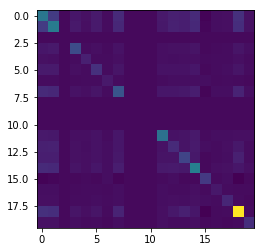

In [7]:
plt.imshow(corex.get_covariance()[:20, :20])
plt.show()

In [8]:
m = corex.moments

In [9]:
for k,v in m.iteritems():
    print k, np.shape(v)

X_i^2 | Y (5038,)
Y_j^2 (10,)
TC_no_overlap ()
I(X_i ; Y) (5038,)
Qij (10, 5038)
rhoinvrho (10, 5038)
I(Y_j ; X) (10,)
MI (10, 5038)
ry (10, 10)
X_i Y_j (5038, 10)
invrho (10, 5038)
Si (5038,)
TCs (10,)
rho (10, 5038)
uj (10,)
Qi (5038,)
X_i Z_j (5038, 10)
additivity ()
TC_direct (10,)
TC ()
